# Continuous TSP Formulation
#### Kalvik Jakkala
#### 801076164

I developed a formulation for the Travelling Salesperson Problem. The problem considers a set of nodes, each of which needs to be visited in an order such that the total distance traveled is minimized.  The problem often arises in path planning when multiple locations of interest have to be visited. 

I was able to accomplish the intended goal. I wanted to develop a continuous formulation for the problem, and my formulation is consistent with TSP. The formulation's global minimum would indeed coincide with the best ordering of the nodes to visit. However, the optimization landscape is relatively large, and finding such an optimal is difficult with first-order solvers such as gradient descent. My model is very susceptible to getting stuck in local optimal. 

I believe the optimization landscape looks like the one shown below. And given the abundance of local minima, stochastic gradient descent is not well suited to solve the problem. Moreover, I don't think higher-order optimization methods will do any good either, as they won't necessarily be able to look past the local valley. 

<img src="TSP_opt.png" style="width: 500px;"/>

The implementation of the method was relatively straightforward once I figured out the formulation. However, it was not clear how one could formulate the problem as the TSP problem is inherently a discrete set problem, and I was trying to convert it into a continuous problem. 

The figure shown below is a result generated with my approach. The path looks reasonably optimal. However, it is not the globally optimal solution. Furthermore, the model's solution converges to is highly dependent on how the model weights are initialized, which is randomly initialized. 

<img src="TSP_path.png" style="width: 500px;"/>

I tried annealing techniques to address the optimal local issue, but it didn't fix the problem. Perhaps Markov Chain Monte Carlo methods might be better suited for optimizing such landscapes. 

However, one thing to consider is that the method, although not practical, is rather interesting. I found some papers that used Deep neural networks to solve the problem, but most of those used Graph neural networks and assumed a training dataset was available. The dataset is a set of arbitrary graphs and the optimal node visitation order as the labels. Such methods are black-box approaches; in contrast, mine is a closed-form formulation. Perhaps we can combine the two techniques to develop a superior method that can leverage the closed-form optimization metric along with the black box approaches excellent performance to reduce the amount of data that is required to train such models. 

#### Formulation

My formulation starts with a randomly generated matrix of size $n \times n$. Where $n$ is the number of nodes in the TSP problem. The matrix columns are interpreted as the step-index of the generated path, and the rows are the node indices. The initial random matrix won't correspond to any valid path. Still, after optimization, the matrix will converge to a solution such that each column assigns a high probability to the node which is supposed to be visited at a particular path step index. 

The optimization formula has two terms. First, we compute the travel distance for the path matrix by applying it to a distance matrix. The distance matrix is a $n \times n$ matrix that contains the pairwise distances between the nodes. Furthermore, the distance matrix's rows can be interpreted as the start node and the column as the destination node. This interpretation allows us to apply the path matrix to the distance by considering two iterators. The first iterator ranges from $0$ to $(n-1)$ and is used to select the column of the path matrix. Each selected column is used as the start node and multiplied across the rows of the distance matrix. The consequence is that if the column of the distance matrix has a high probability at node $0$, only the row which gives the distances of edges that start from node 0 remain in the distance matrix. 

Similarly, a second iterator ranges from $1$ to $n$ and is used to select the columns of the path matrix but, this selected column is applied to the columns of the distance matrix. This, in turn, results in reducing the distance matrix to a single entry which gives the cost of traversing a single edge. The output of the two iterators is summed to get the total path cost. The method is entirely differentiable and can be used to optimize the path matrix. 

<img src="opt_setup.png" style="width: 800px;"/>

However, it is possible for the optimized to select the same node in every column, which will result in a total path cost of 0. We can address this problem with an entropy constraint. By requiring each row of the path matrix to have high entropy, we can enforce a path constraint on the model. We want to avoid selecting the same node in multiple columns; requiring the entropy of each row to be high will make sure that the row has a single mode, thereby maximizing the entropy. 

The path matrix is optimized jointly with the two optimization terms combined with a lagragian term. I used the Adam optimized to oprimized model. 

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
num_nodes = 10 # number of nodes in the TSP probelm
epochs = 1000 # number of epochs to train the model for
device = torch.device('cpu')

# Generate random point locations and compute pairwise distances
locs = np.random.rand(num_nodes, 2)*100
dist_mat = squareform(pdist(locs, 'euclidean'))
np.fill_diagonal(dist_mat, 1000.)
dist_mat = torch.from_numpy(dist_mat)

243.98017265310727
model loss


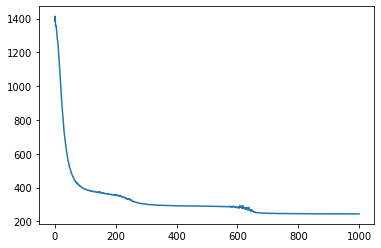

model predicted path


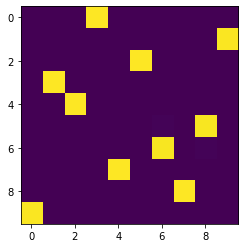

[9 3 4 0 7 2 6 8 5 1]


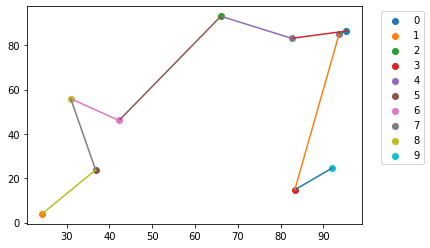

In [3]:
'''
Class to setup TSP problem as a continuous optimization problem
'''
class TSP(nn.Module):
    def __init__(self, num_nodes):
        super().__init__()
        self.num_nodes = num_nodes 
        # Weight matrix that is optimized to solve the problem
        self.weights = torch.nn.Parameter(torch.rand((num_nodes, num_nodes), 
                                                     dtype=torch.float64),
                                          requires_grad=True)
        self.softmax0 = nn.Softmax(dim=0)
        self.loss_lambda = torch.nn.Parameter(torch.tensor(0.5), 
                                              requires_grad=False)
               
    def forward(self, dist_mat):
        # compute softmax to concentrate predictions into point masses
        assign_mat = self.softmax0(self.weights)
        
        # apply softmax predicted path to distance matrix and compute total path length
        assign_mat_start = torch.zeros_like(assign_mat)
        assign_mat_start[:, :-1] = assign_mat[:, :-1]
        node_ids = torch.unsqueeze(assign_mat_start, 0).T*dist_mat
        assign_mat_to = torch.zeros_like(assign_mat)
        assign_mat_to[:, :-1] = assign_mat[:, 1:]
        node_ids = torch.unsqueeze(assign_mat_to, 1).T*node_ids     
        path_length = torch.sum(node_ids)
        
        # Add constrainet to make sure each node is selected only once in the path
        row_sums = torch.sum(assign_mat, dim=1)
        spread_cost = torch.sum(torch.abs(torch.ones(self.num_nodes)-row_sums))
        
        return self.loss_lambda*(200.*(spread_cost)) + path_length, assign_mat

    
# Create TSP model and use Adam optimized to optimize the model
model = TSP(num_nodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1) 
        
loss_plot = []
lamb = []
for epoch in range(epochs):      
    loss, predictions = model(dist_mat)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_plot.append(loss.detach().cpu().numpy())
    model.loss_lambda.data = torch.tensor(0.5+0.01*np.sin(0.1*epoch))
    path = np.argmax(predictions.detach().cpu().numpy(), axis=0)
    
# Plot model loss
print(loss_plot[-1])
print("model loss")
plt.plot(loss_plot)
plt.show()

# Plot predicted path matrix 
print("model predicted path")
plt.imshow(predictions.detach().cpu().numpy())
plt.show()

# Plot predicted path
path = np.argmax(predictions.detach().cpu().numpy(), axis=0)
print(path)
for i, loc in enumerate(locs):
    plt.scatter(loc[0], loc[1], label=i)
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

for i in range(len(path)-1):
    plt.plot(locs[path[i:i+2], 0], locs[path[i:i+2], 1])

#### References:
http://iid.yale.edu/files/icml-2020/module3.pdf (Optimization landscape figure)

#### Libraries:

* Linear Algebra: https://numpy.org/
* Plotting: https://matplotlib.org/
* Backpropagation: https://pytorch.org/